In [1]:
%matplotlib inline

In [2]:
import numpy as np 
from scipy.integrate import odeint
from orbits import elliptic_orbit
import mass_function

from tqdm import tqdm

import matplotlib as mpl
mpl.rcParams['font.size'] = 18.0

In [3]:
import matplotlib.pyplot as plt

#### Constants etc

In [4]:
km_to_pc = 3.24078e-14 #pc/km
G_N = 4.302e-3*(3.24078e-14)**2 #(pc/M_sun) (pc/s)^2

year = 365.24*24*60*60

kg_to_J = 9e16 #J/kg
Msun_to_kg = 2e30 #kg/Msun
Msun_to_J = Msun_to_kg*kg_to_J #J/Msun

#MW NFW halo properties
rho0 =  1.4e7*1e-9 # Msun pc^-3, see Table 1 in 1304.5127
rs   = 16.1e3      # pc

#NS properties
R_NS = 10*km_to_pc #pc
M_NS = 1.4 #M_sun
vesc_NS = np.sqrt(2*G_N*M_NS/R_NS) #pc/s

#### NS heating

In [5]:
r_list = np.geomspace(1, 50e3, 100)

#DM density profile
x_list = r_list/rs
rho_list = rho0/(x_list*(1+x_list)**2)

#Calculate the orbital period and velocity at each radius
T_orb_list = 0.0*r_list
for i, r in enumerate(r_list):
    orb = elliptic_orbit(a=r, e=0.0)
    T_orb_list[i] = orb.T_orb
v_orb_list = (2*np.pi*r_list)/T_orb_list

#Gravitational focusing factor
focus_factor = (1 + vesc_NS**2/v_orb_list**2)
    
#Maximum rate of DM capture/energy injection is if all DM in the path of the NS is 'consumed'
dQdt = rho_list*np.pi*R_NS**2*v_orb_list*focus_factor

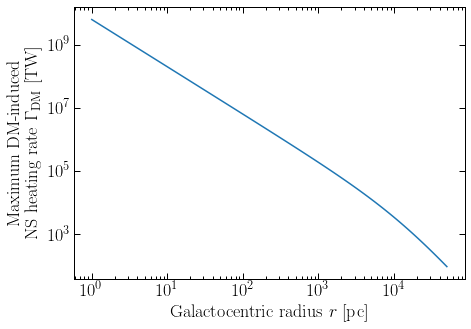

In [6]:
plt.figure(figsize=(7,5))

plt.loglog(r_list, dQdt*Msun_to_J/1e12)

plt.xlabel(r"Galactocentric radius $r$ [pc]")
plt.ylabel("Maximum DM-induced \n NS heating rate $\\Gamma_\\mathrm{DM}$ [TW]")

plt.show()

#### Temperature evolution

[We're following some of the ideas in https://arxiv.org/abs/2010.00015 here.]

Next solve:

$$\frac{\mathrm{d}T}{\mathrm{d}t} = (\Gamma_\mathrm{in} + \Gamma_\mathrm{DM} - \Gamma_\mathrm{emission})/C(T)$$

where
$$ \Gamma_\mathrm{emission} = 4 \pi R_\mathrm{NS}^{2} \sigma_{\mathrm{SB}} T^{4} \epsilon $$

is the energy lost to thermal emission and $\Gamma_\mathrm{in}$ is the internal heat flow from the NS. We'll fix $\Gamma_\mathrm{in}$ by requiring that the internal heat flow is sufficient to maintain equilibrium at an initial temperature of $T_0 = 10^3 \,\mathrm{K}$ in the absence of DM. That is, we fix:

$$\Gamma_\mathrm{in} = 4 \pi R_\mathrm{NS}^{2} \sigma_{\mathrm{SB}} T_0^{4} \epsilon$$

With that, we just solve for the final temperature of the NS (depending on the rate of DM energy injection $\Gamma_\mathrm{DM}$.

We'll fix the emissivity $\epsilon = 10^{-2}$, although that's probably a bit small (making $\epsilon$ bigger just lowers the final temperature achieved by the NS). Finally, we assume the heat capacity of the NS as:

$$ C(T) = 10^{31} \left(\frac{T}{10^8 \,\mathrm{K}}\right) \,\mathrm{J/K}$$

(see e.g. https://www.int.washington.edu/talks/WorkShops/int_16_2b/People/Reddy_S/Reddy.pdf).

In [7]:
T0 = 1e3

#Stefan-Boltzmann Constant
sig_B =  5.67e-8 #W/m^2/K^4

def dTdt_NS(T, t, Gamma_DM=1e12):
    epsilon = 1e-2
    Gamma_in = epsilon*4*np.pi*(1e4)**2*sig_B*(T0)**4 #J/s
    Gamma_em = epsilon*4*np.pi*(1e4)**2*sig_B*(T)**4 #J/s
    #print(Gamma_em/1e12)
    C = 1e31*(T/1e8) #J/K
    return (Gamma_in + Gamma_DM - Gamma_em)/C

In [8]:
t_list = np.geomspace(1, 13e9, 10000)
def calcT_final(Gamma_DM):
    res = odeint(dTdt_NS, T0, t_list*year, args=(Gamma_DM,))
    return res[-1,0] #Return the final temperature

In [9]:
T_list = 0.0*r_list
T_list_1pc = 0.0*r_list
T_list_tiny = 0.0*r_list
for i, Gamma in enumerate(dQdt*Msun_to_J):
    T_list[i] = calcT_final(Gamma)
    T_list_1pc[i] = calcT_final(Gamma*1e-2)
    T_list_tiny[i] = calcT_final(Gamma*1e-6)

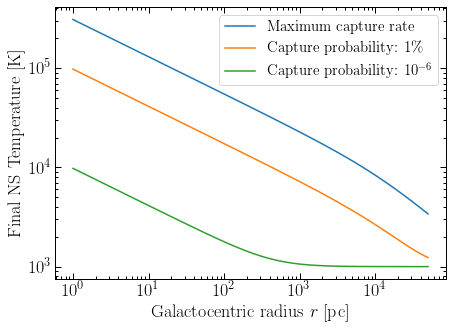

In [10]:
plt.figure(figsize=(7,5))

plt.loglog(r_list, T_list, label="Maximum capture rate")
plt.loglog(r_list, T_list_1pc, label=r"Capture probability: 1\%")
plt.loglog(r_list, T_list_tiny, label=r"Capture probability: $10^{-6}$")

plt.xlabel(r"Galactocentric radius $r$ [pc]")
plt.ylabel(r"Final NS Temperature [K]")

plt.legend()

plt.show()

#### Accounting for miniclusters/substructure

[See e.g. https://arxiv.org/abs/1908.00747, esp. Fig. 7 for a related discussion about DM capture in the Sun.]

The AMC encounter rate for a single NS is given by:

$$ \Gamma_\mathrm{enc} = n_\mathrm{AMC} \langle \sigma u \rangle \approx f_{\mathrm{AMC}} \frac{\rho_{\mathrm{DM}}(r)}{\left\langle M_{\mathrm{AMC}}\right\rangle} \times \sqrt{8 \pi} v_\mathrm{orb}(r) R^2$$

Let's simplify things and take: $M_\mathrm{AMC} = \langle M_\mathrm{AMC}\rangle \approx 10^{-14} \,M_\odot$. Let's also assume that the AMCs are spheres of constant density $\rho_\mathrm{AMC} = 10^6 \,M_\odot\,\mathrm{pc}^{-3}$. The typical minicluster radius is then: $R_\mathrm{AMC} = ((3 M_\mathrm{AMC})/(4\pi\rho_\mathrm{AMC}))^{1/3}$.

We'll also set $f_\mathrm{AMC} = 1$ and we'll focus on r = 1 pc.

In [11]:
#Number density of miniclusters:
AMC_MF = mass_function.PowerLawMassFunction(m_a = 20e-6, gamma = -0.7)
M_AMC = AMC_MF.mavg #M_sun
rho_AMC = 1e6 #M_sun/pc^3
R_AMC = ((3*M_AMC)/(4*np.pi*rho_AMC))**(1/3) #pc
print("R_AMC [pc]:", R_AMC)

#Typical crossing time at r = 1 pc:
T_cross = R_AMC/v_orb_list[0]
print("T_cross [yr]:", T_cross/year) #The crossing time is typically much less than a year, so we can take it as instantaneous

R_AMC [pc]: 1.4904938364788493e-07
T_cross [yr]: 0.05904607064069909


In [12]:
Gamma_enc_list = year*np.sqrt(8*np.pi)*(rho_list/M_AMC)*v_orb_list*R_AMC**2
deltat = 1/Gamma_enc_list[0]
print(Gamma_enc_list[0], " AMC encounters per year at r = 1 pc")
print("... or roughly one encounter every ", deltat, " years")

0.004568149227391172  AMC encounters per year at r = 1 pc
... or roughly one encounter every  218.90703438580326  years


Let's study the behaviour of the system over a short period of time:

In [13]:
deltaQ_max = M_AMC #Maximum injection of energy is if you eat the whole 
deltaQ = rho_AMC*np.pi*R_NS**2*v_orb_list[0]*focus_factor[0]*T_cross #Energy injected during the crossing

print(deltaQ, deltaQ_max)

#Change in temperature due to energy injected by AMC
deltaT = deltaQ*Msun_to_J/(1e31*(1e3/1e8))

#Evolve until (roughly) the next AMC crossing
t_list_short = np.linspace(0, 220, 100)
res = odeint(dTdt_NS, T0+deltaT, t_list_short*year, args=(0,))

3.0002879129888215e-16 1.3870086282009611e-14


In [14]:
print(rho_list[0])
print(rho_AMC*deltat/T_cross) #Mean DM density encountered by the NS should be roughly the same

225.3720026084796
117.48343583901263


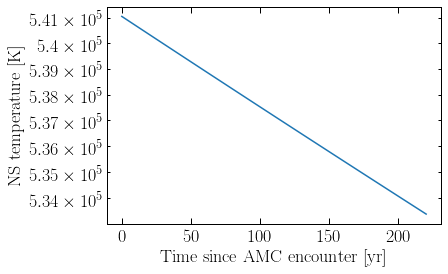

In [15]:
plt.figure()

plt.semilogy(t_list_short, res[:,0])

plt.xlabel("Time since AMC encounter [yr]")
plt.ylabel("NS temperature [K]")

plt.show()

Now let's consider evolving over O(1000) AMC encounters to see how the system behaves. With each encounter, we'll just bump up the temperature of the AMC, according to how much energy is injected (assuming as usual that all the DM encountered by the AMC is converted to energy).

In [16]:
N_enc = 1000
T_NS = 1e3 #Initial NS mass
T_NS_list = np.zeros(N_enc)
for i in tqdm(range(N_enc)):
    T_NS_list[i] = T_NS
    deltaT = deltaQ*Msun_to_J/(1e31*(T_NS/1e8)) #delta T = delta Q/C(T)
    T_NS += deltaT
    #Evolve until the next encounter (assuming they're equally spaced)
    t_list_short = np.linspace(0, 220, 50)
    res = odeint(dTdt_NS, T_NS, t_list_short*year, args=(0,))
    T_NS = res[-1,0]

100%|██████████| 1000/1000 [00:00<00:00, 4654.04it/s]


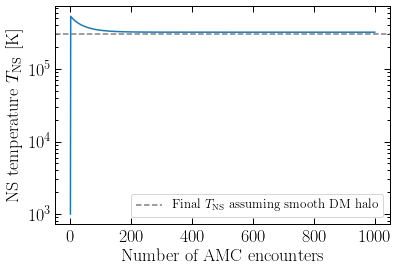

In [22]:
plt.figure()

plt.semilogy(T_NS_list)

#print("The grey line is the final NS temperature assuming a smooth DM halo.")
plt.axhline(T_list[0], linestyle='--', color='grey', label=r'Final $T_\mathrm{NS}$ assuming smooth DM halo')

plt.xlabel('Number of AMC encounters')
plt.ylabel(r'NS temperature $T_\mathrm{NS}$ [K]')

plt.legend(fontsize=13)

plt.show()